In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 2. Dummy Dataset
english_sentences = [
    'hello', 'how are you', 'what is your name', 'good morning',
    'good night', 'thank you', 'sorry', 'yes', 'no', 'please',
    'where are you', 'i love you', 'what time is it', 'i am fine',
    'see you later', 'goodbye', 'i am hungry', 'i am tired',
    'what is this', 'where is the station', 'come here', 'go there',
    'open the door', 'close the window', 'sit down', 'stand up',
    'be careful', 'congratulations', 'happy birthday'
]

hindi_sentences = [
    'नमस्ते', 'आप कैसे हैं', 'आपका नाम क्या है', 'सुप्रभात',
    'शुभ रात्रि', 'धन्यवाद', 'माफ़ कीजिए', 'हाँ', 'नहीं', 'कृपया',
    'आप कहाँ हैं', 'मैं आपसे प्यार करता हूँ', 'समय क्या हुआ है', 'मैं ठीक हूँ',
    'बाद में मिलते हैं', 'अलविदा', 'मुझे भूख लगी है', 'मैं थक गया हूँ',
    'यह क्या है', 'स्टेशन कहाँ है', 'यहाँ आओ', 'वहाँ जाओ',
    'दरवाजा खोलो', 'खिड़की बंद करो', 'बैठ जाओ', 'खड़े हो जाओ',
    'सावधान रहो', 'बधाई हो', 'जन्मदिन मुबारक हो'
]

In [4]:
# 3. Tokenizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_tokenizer = Tokenizer(filters='')
hin_tokenizer = Tokenizer(filters='')

eng_tokenizer.fit_on_texts(english_sentences)
hin_tokenizer.fit_on_texts(hindi_sentences)

eng_vocab_size = len(eng_tokenizer.word_index) + 1
hin_vocab_size = len(hin_tokenizer.word_index) + 1

In [5]:
# 4. Preprocess
input_seq = eng_tokenizer.texts_to_sequences(english_sentences)
target_seq = hin_tokenizer.texts_to_sequences(hindi_sentences)

input_seq = pad_sequences(input_seq, padding='post')
target_seq = pad_sequences(target_seq, padding='post')

In [6]:
# Target input and target output (for teacher forcing)
decoder_input = target_seq[:, :-1]
decoder_output = target_seq[:, 1:]

In [7]:
# 5. Build Encoder-Decoder Model
embed_dim = 64
units = 128

In [8]:
# Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
encoder_emb = tf.keras.layers.Embedding(eng_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs, state_h = tf.keras.layers.GRU(units, return_state=True)(encoder_emb)

In [9]:
# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
decoder_emb = tf.keras.layers.Embedding(hin_vocab_size, embed_dim)(decoder_inputs)
decoder_gru = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_gru(decoder_emb, initial_state=state_h)
decoder_dense = tf.keras.layers.Dense(hin_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [10]:
# Model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │      3,136 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 64)  │      3,520 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 128),     │     74,496 │ embedding[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, None,     │     74,496 │ embedding_1[0][0… │
│                     │ 128), (None,      │            │ gru[0][1]         │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 55)  │      7,095 │ gru_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 162,743 (635.71 KB)

 Trainable params: 162,743 (635.71 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 6. Train
history = model.fit(
    [input_seq, decoder_input],
    decoder_output[..., np.newaxis],
    batch_size=4,
    epochs=200,
    validation_split=0.2
)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.3368 - loss: 3.9801 - val_accuracy: 0.6250 - val_loss: 3.8855
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6175 - loss: 3.8157 - val_accuracy: 0.6250 - val_loss: 3.6528
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6148 - loss: 3.4862 - val_accuracy: 0.6250 - val_loss: 3.0547
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6846 - loss: 2.5070 - val_accuracy: 0.6250 - val_loss: 1.9220
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5827 - loss: 1.8675 - val_accuracy: 0.6250 - val_loss: 2.3741
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6484 - loss: 1.6873 - val_accuracy: 0.6250 - val_loss: 2.0121
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5929 - loss: 1.6593 - val_accuracy: 0.6250 - val_loss: 1.9454
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6054 - loss: 1.6050 - val_accuracy: 0.6250 - val_loss

In [12]:
# 7. Save the model
model.save('translator.h5')
import pickle

with open('eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)
with open('hin_tokenizer.pkl', 'wb') as f:
    pickle.dump(hin_tokenizer, f)

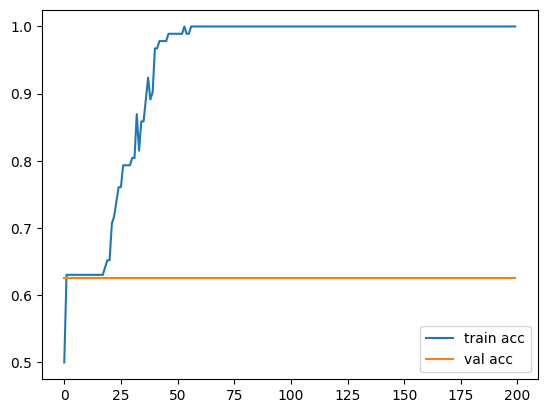

In [13]:
# 8. Plot Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()